# Lab 02 - Multi-Objective Optimization
## Tasks
- Learn to solve optimization problems using the Xopt package
- Conduct multi-objective optimization on AWA photoinjector example

## Set up environment

In [ ]:
!pip install xopt==2.5.2
!pip install pygmo

In [ ]:
%reset -f
from google.colab import drive
import os

drive.mount('/content/drive')
path = '/content/drive/MyDrive/USPAS_ML-master/lab_02_multi_objective_optimization'
os.chdir(path)
!ls

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xopt

import torch

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Multi-objective optimization of a test problem


Our goal is to find the ideal trade-off between two objectives $f_1,f_2$. We will use a problem selected from a collection of test problems known as the ZDT problem suite. The following explaination is from (https://github.com/anyoptimization/pymoo/blob/main/docs/source/problems/multi/zdt.ipynb) which discusses the entire collection.

### ZDT

The ZDT <cite data-cite="zdt"></cite> problem suite is based on the construction process

\begin{align}
\begin{split}
\min && \; f_1(x)\\
\min && \; f_2(x) = g(x) \, h(f_1(x),g(x))
\end{split}
\end{align}

where two objective have to be minimized. The function $g(x)$ can be considered as the function for convergenece  and usually $g(x) = 1$ holds for pareto-optimal solutions (except for ZDT5).

### ZDT1

This is a n-D variable problem (here we will use $n=10$) with a convex Pareto-optimal set:

**Definition**

\begin{align}
\begin{split}
f_1(x) &= \, & x_1 \\
g(x) &=& 1 + \frac{9}{n-1} \; \sum_{i=2}^{n} x_i \\
h(f_1,g) &=& 1 - \sqrt{f_1/g} \\
\end{split}
\end{align}


$$0 \leq x_i \leq 1 \quad i=1,\ldots,n$$

**Optimum**

$$0 \leq x_1^* \leq 1  \quad \text{and} \quad x_i^*=0 \; \text{for} \; i=2,\ldots,n$$


To solve this problem we will use the evolutionary CNSGA algorithm, implmented in Xopt.

## Defining the problem in Xopt

Xopt can interface with arbitrary evaluate functions (defined in Python) with the
following form:
```python
def evaluate(inputs: dict) -> dict:
    """ your code here """
```
Evaluate functions must accept a dictionary object that **at least** has the keys
specified in `variables, constants` and returns a dictionary
containing **at least** the
keys contained in `objectives, constraints`. Extra dictionary keys are tracked and
used in the evaluate function but are not modified by xopt.

In [ ]:
from xopt import Evaluator

# define the problem as a python callable
n_dims = 10
def evaluate(input_dict):
    x = np.array([input_dict[f"x{i + 1}"] for i in range(n_dims)])

    f1 = x[0]
    g = 1 + (9 / (n_dims - 1)) * np.sum(x[1:])
    h = 1 - np.sqrt(f1 / g)
    f2 = g * h

    return {"f1": f1, "f2": f2, "g": g}

evaluator = Evaluator(function=evaluate)

## Define the variables and objectives
Next we define the variables and objectives for our problem in a `VOCS` object.

In [ ]:
from xopt import VOCS
vocs = VOCS(
    variables={f"x{i + 1}": [0, 1] for i in range(n_dims)},
    objectives={"f1": "MINIMIZE", "f2": "MINIMIZE"},
)
vocs.model_dump()

## Define the optimization algorithm

In [ ]:
from xopt.generators.ga import CNSGAGenerator
generator = CNSGAGenerator(
    vocs=vocs,
    population_size=64,
    crossover_probability=0.75,
    mutation_probability=0.25
)
generator.model_dump()

## Combine the evaluator, vocs, and generator objects into the Xopt object

In [ ]:
from xopt import Xopt
X = Xopt(
    vocs=vocs,
    generator=generator,
    evaluator=evaluator
)

In [ ]:
generations = 100
for _ in range(64 * generations):
    X.step()

In [ ]:
X.data.plot.scatter(x="f1",y="f2",c=X.data.index,cmap="viridis")

> ### **Task**
> Plot the Pareto front and calculate the front hypervolume with the reference point (11,11). See `fast_non_dominated_sorting` in https://esa.github.io/pygmo2/tutorials/moo.html and `hypervolume` in https://esa.github.io/pygmo2/tutorials/hypervolume.html .

# Multi-objective optimization of the AWA photoinjector


Here we will find the pareto front of the AWA photoinjector problem (see below).
Input variables are shown in red and output variables are shown in blue. Both the
inputs and outputs are normalized to [-1,1]. Our goal is to minimize all of the
output beam parameters. To model the AWA beamline dynamics we use a pre-compiled, fast
executing neural network surrogate model (that you will have a chance to build in lab
 5!). The inputs to this model are `[P0, P1, G0, G1, K1, K2]` and the outputs are
 `[rms_x, rms_y, rms_s, emit_x, emit_y, emit_s, dE]`.



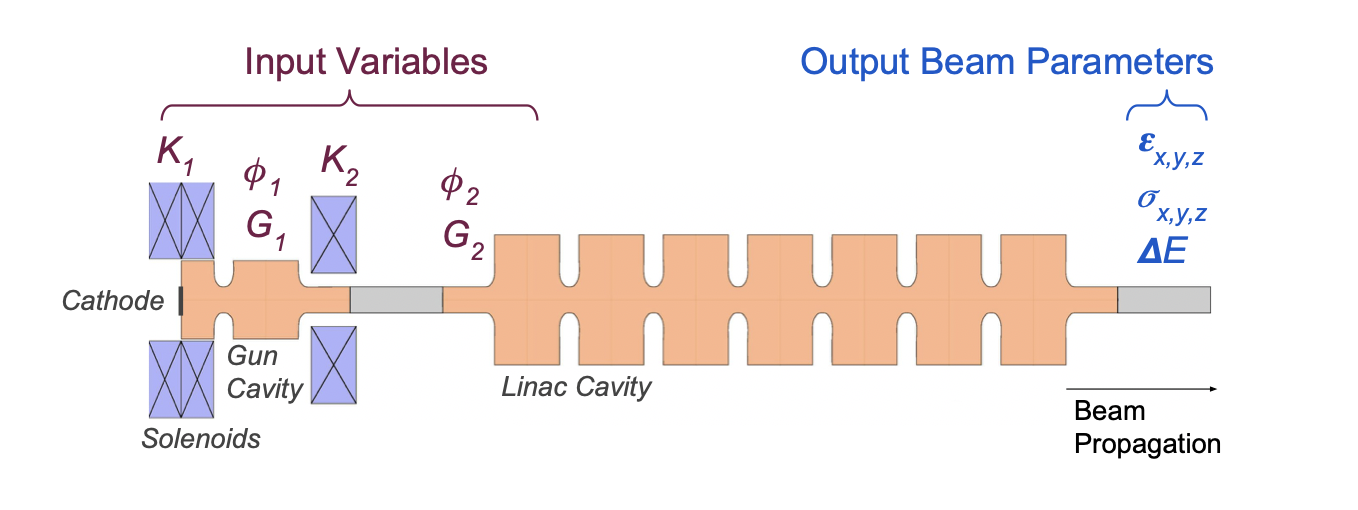

In [ ]:
# get AWA model
awa_model = torch.jit.load("awa_model.pt")

# test awa_model
x = torch.rand(6)
awa_model(x)

In [ ]:
# define variables and objectives in VOCS object
awa_vocs = VOCS(
    variables={
        'P0':[-1.0,1.0],
        'P1':[-1.0,1.0],
        'G0':[-1.0,1.0],
        'G1':[-1.0,1.0],
        'K1':[-1.0,1.0],
        'K2':[-1.0,1.0]
    },
    objectives={
        'rms_x':"MINIMIZE",
        'rms_y':"MINIMIZE",
        'rms_s':"MINIMIZE",
        'emit_x':"MINIMIZE",
        'emit_y':"MINIMIZE",
        'emit_s':"MINIMIZE",
        'dE':"MINIMIZE"
    }
)

> ### **Task**
> Use the above code to find the 7D pareto front of the AWA multi-objective problem. Plot the front projected onto the bunch length vs. horizontal emittance subspace.

> Note: when evaluating the NN model, you should call `detach().numpy()` to convert the output of the model into a numpy array.

# **Homework**
Another approach to solving multi-objective problems is to specify explicit weights that rate the relative importance of each objective. In this case the problem is single objective and can be solved by a variety of single objective algorithms, including RCDS. Use the Xopt `RCDSGenerator` generator (see https://xopt.xopt.org/examples/rcds/rcds/ for an example) to solve for multiple different objective trade-offs of the ZDT1 problem
- even weighting between all objectives
- weight `f1 = 2*f2` with all others equal weighting with respect to rms_s
- weight `f2 = 2*f1` with all others equal weighting with respect to rms_s

Plot the `f1,f2` function values found to minimize the three problems on an axis that also contains the ZDT1 pareto front. How do these solutions compare to the Pareto front in objective space?